In [247]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 


In [248]:
df = pd.read_csv("final_dataset_LSTM.csv.gz").drop("Unnamed: 0", axis=1)
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [249]:
AAPL_stock = df[df["Stock"]==0]
LLY_stock = df[df["Stock"]==1]
NEE_stock = df[df["Stock"]==2]
stock_datasets = [AAPL_stock, LLY_stock, NEE_stock]

In [250]:
AAPL_stock = AAPL_stock.drop(["Stock"], axis=1).set_index("time_stamp")
AAPL_stock

,volatility,MA_1_log_return,MA_5_log_return,MA_22_log_return,MA_44_log_return,MA_1_volatility,MA_5_volatility,MA_22_volatility,MA_44_volatility,MA_1_volume,MA_5_volume,MA_22_volume,MA_44_volume,CALENDAR_DAYS,QUARTERLY_EARNINGS
time_stamp,,,,,,,,,,,,,,,
2020-03-06,0.001461,-0.011603,0.014552,0.000846,0.000877,0.001197,0.001936,0.001052,0.000802,4929.640368,5084.752690,4820.954299,4795.661361,0,5
2020-03-09,0.002529,0.028879,0.008139,0.001962,0.001219,0.001461,0.001623,0.001093,0.000825,4994.925196,5039.090881,4831.785040,4800.693345,0,5
2020-03-10,0.001978,0.008389,-0.000968,0.002626,0.001462,0.002529,0.001815,0.001180,0.000869,4924.218329,4990.899754,4841.835622,4804.024129,0,5
2020-03-11,0.001702,0.022914,0.012900,0.003370,0.001635,0.001978,0.001687,0.001248,0.000904,5101.090690,4985.515579,4862.155744,4812.535856,0,5
2020-03-12,0.003599,-0.014601,0.006796,0.003107,0.001434,0.001702,0.001773,0.001298,0.000933,5070.530383,5004.080993,4878.381499,4822.092545,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-24,0.000509,-0.007881,0.005271,0.002849,0.000649,0.000534,0.000593,0.000583,0.000624,4466.857458,4506.695064,4404.854790,4419.464743,0,5
2025-09-25,0.000627,-0.012383,0.003175,0.001963,0.000444,0.000509,0.000590,0.000574,0.000626,4274.619264,4490.736161,4402.532860,4417.684236,0,5
2025-09-26,0.000486,0.010293,0.007236,0.002287,0.000683,0.000627,0.000605,0.000582,0.000627,4433.780195,4509.974987,4411.400165,4419.863425,0,5


In [251]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

    

In [252]:
values = AAPL_stock.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[list(range(16,30))], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.176106   0.430942   0.686974   0.621267   0.582943   0.136568   
2   0.335895   0.581989   0.582026   0.669455   0.611756   0.176106   
3   0.253425   0.505537   0.433011   0.698111   0.632247   0.335895   
4   0.212121   0.559730   0.659941   0.730206   0.646896   0.253425   
5   0.496205   0.419755   0.560052   0.718846   0.629954   0.212121   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.597973   0.357094   0.313173    0.876661    0.974640    0.724315   
2   0.481935   0.380101   0.332277    0.909922    0.932077    0.736517   
3   0.553059   0.427934   0.369267    0.873899    0.887157    0.747840   
4   0.505715   0.466038   0.398294    0.964011    0.882138    0.770733   
5   0.537743   0.493700   0.421806    0.948441    0.899444    0.789013   

   var13(t-1)  var14(t-1)  var15(t-1)   var1(t)  
1    0.773949         0.0         1.0  0.335895  
2    0.780766         0.0   

In [191]:
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 15) (1214,) (185, 1, 15) (185,)


In [192]:
def lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [193]:
lstm_regressor = KerasRegressor(
    model=lstm_model,
    verbose=0,
    epochs=50,
    batch_size=72,
    shuffle=False
)
param_grid = {
    'model__units': [32,64,128],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32,64],
    'epochs': [25,50]
}
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

grid_search = GridSearchCV(
    estimator=lstm_regressor,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=1
)

In [194]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.1s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.7s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.1s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32,

In [195]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0387
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 32}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
30        -0.038709                  32                       0.001   
18        -0.038808                  32                       0.010   
22        -0.038842                  64                       0.001   
21        -0.039067                  32                       0.001   
19        -0.039234                  64                       0.010   

    param_batch_size  param_epochs  
30                64            50  
18                64            25  
22                64            25  
21                64            25  
19                64            25  


In [ ]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_

In [230]:
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

In [234]:
def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

In [ ]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)


1. Final RMSE (Root Mean Squared Error): 0.0541
MSE:  0.0029246665071696043
AIC:  -7049.1738308018
BIC:  -6962.44533928427


In [256]:
reframed = reframed.drop(["var14(t-1)", "var15(t-1)"], axis=1)
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1214, 1, 13) (1214,) (185, 1, 13) (185,)


In [257]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.5s
[CV] END batch_size=32,

In [258]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0383
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 128}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
32        -0.038266                 128                       0.001   
22        -0.038765                  64                       0.001   
21        -0.038857                  32                       0.001   
2         -0.038883                 128                       0.010   
14        -0.038986                 128                       0.001   

    param_batch_size  param_epochs  
32                64            50  
22                64            25  
21                64            25  
2                 32            25  
14                32            50  


In [259]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0553
MSE:  0.0030621334444731474
AIC:  -6993.413089876866
BIC:  -6906.684598359336


In [265]:
reframed = reframed[["var1(t-1)", "var1(t)"]]
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 1) (1214,) (185, 1, 1) (185,)


In [266]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.5s
[CV] END batch_size=32,

In [267]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0418
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 128}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
32        -0.041768                 128                       0.001   
27        -0.041906                  32                       0.010   
14        -0.042267                 128                       0.001   
28        -0.042324                  64                       0.010   
31        -0.042379                  64                       0.001   

    param_batch_size  param_epochs  
32                64            50  
27                64            50  
14                32            50  
28                64            50  
31                64            50  


In [268]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0554
MSE:  0.003074413165450096
AIC:  -6988.554461038228
BIC:  -6901.825969520697


Epoch 1/50
17/17 - 1s - 50ms/step - loss: 0.0359 - val_loss: 0.0335
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0344 - val_loss: 0.0323
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0350 - val_loss: 0.0341
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0285 - val_loss: 0.0324
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0270 - val_loss: 0.0295
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0266 - val_loss: 0.0282
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0265 - val_loss: 0.0279
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0265 - val_loss: 0.0278
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0261 - val_loss: 0.0276
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0257 - val_loss: 0.0274
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0254 - val_loss: 0.0274
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0252 - val_loss: 0.0272
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0248 - val_loss: 0.0269
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0246 - val_loss: 0.0268
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0245 - val_l

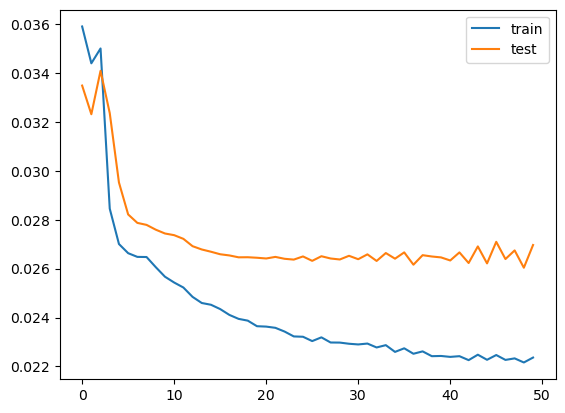

In [55]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [56]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)
print('Test RMSE: %.3f' % rmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.00037543180590254014
Test RMSE: 0.000


In [269]:
LLY_stock = LLY_stock.drop(["Stock"], axis=1).set_index("time_stamp")


In [270]:
values = LLY_stock.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[list(range(16,30))], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.274373   0.454379   0.635926   0.328606   0.419818   0.163607   
2   0.408829   0.638316   0.757537   0.393574   0.490524   0.274373   
3   0.356351   0.507221   0.761063   0.399313   0.497253   0.408829   
4   0.288847   0.504218   0.922432   0.434863   0.510453   0.356351   
5   0.881169   0.477698   0.817667   0.483018   0.513913   0.288847   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.353420   0.147862   0.078819    0.768948    0.734414    0.603145   
2   0.319647   0.173195   0.098137    0.764580    0.732890    0.629702   
3   0.357533   0.211589   0.127555    0.642275    0.694453    0.624693   
4   0.342737   0.245167   0.156432    0.712885    0.688532    0.642279   
5   0.367543   0.271865   0.178462    0.760160    0.704484    0.674037   

   var13(t-1)  var14(t-1)  var15(t-1)   var1(t)  
1    0.643214         0.0         1.0  0.408829  
2    0.665607         0.0   

In [271]:
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 15) (1214,) (185, 1, 15) (185,)


In [240]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.1s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32,

In [241]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0739
Best Parameters: {'batch_size': 64, 'epochs': 25, 'model__learning_rate': 0.001, 'model__units': 64}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
22        -0.073912                  64                      0.0010   
23        -0.074025                 128                      0.0010   
12        -0.074541                  32                      0.0010   
16        -0.074651                  64                      0.0001   
21        -0.074734                  32                      0.0010   

    param_batch_size  param_epochs  
22                64            25  
23                64            25  
12                32            50  
16                32            50  
21                64            25  


In [242]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0752
MSE:  0.005650063510984182
AIC:  -6249.771430507839
BIC:  -6163.042938990308


In [272]:
reframed = reframed.drop(["var14(t-1)", "var15(t-1)"], axis=1)
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 13) (1214,) (185, 1, 13) (185,)


In [273]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.5s
[CV] END batch_size=32,

In [274]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0742
Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 32}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
12        -0.074165                  32                      0.0010   
30        -0.074605                  32                      0.0010   
22        -0.074626                  64                      0.0010   
17        -0.074683                 128                      0.0001   
7         -0.074788                  64                      0.0001   

    param_batch_size  param_epochs  
12                32            50  
30                64            50  
22                64            25  
17                32            50  
7                 32            25  


In [275]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0734
MSE:  0.005394028499722481
AIC:  -6306.069803607351
BIC:  -6219.34131208982


In [276]:
reframed = reframed[["var1(t-1)", "var1(t)"]]
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 1) (1214,) (185, 1, 1) (185,)


In [277]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.5s
[CV] END batch_size=32,

In [278]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0743
Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.0001, 'model__units': 128}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
17        -0.074337                 128                      0.0001   
21        -0.074373                  32                      0.0010   
35        -0.074425                 128                      0.0001   
8         -0.074650                 128                      0.0001   
22        -0.074721                  64                      0.0010   

    param_batch_size  param_epochs  
17                32            50  
21                64            25  
35                64            50  
8                 32            25  
22                64            25  


In [279]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0805
MSE:  0.006483942735940218
AIC:  -6082.649779185234
BIC:  -5995.921287667704


Epoch 1/50


/opt/miniconda3/envs/myenv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 - 1s - 52ms/step - loss: 0.0618 - val_loss: 0.0546
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0546 - val_loss: 0.0502
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0498 - val_loss: 0.0492
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0485 - val_loss: 0.0479
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0469 - val_loss: 0.0480
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0456 - val_loss: 0.0477
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0446 - val_loss: 0.0473
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0438 - val_loss: 0.0466
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0431 - val_loss: 0.0462
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0426 - val_loss: 0.0459
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0422 - val_loss: 0.0457
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0419 - val_loss: 0.0453
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0416 - val_loss: 0.0451
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0413 - val_loss: 0.0451
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0411 - val_loss: 0.0451

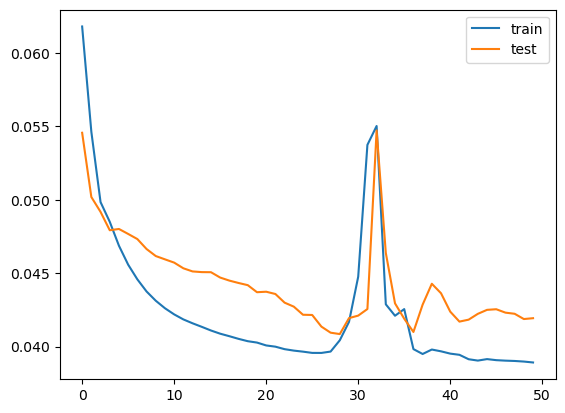

In [60]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)
print('Test RMSE: %.3f' % rmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.0003086279353541977
Test RMSE: 0.000


In [280]:
NEE_stock = NEE_stock.drop(["Stock"], axis=1).set_index("time_stamp")

In [281]:
values = NEE_stock.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[list(range(16,30))], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.249763   0.558907   0.659749   0.734461   0.671267   0.160647   
2   0.387782   0.592810   0.588869   0.753383   0.696356   0.249763   
3   0.363053   0.706041   0.519444   0.776083   0.728227   0.387782   
4   0.280799   0.356199   0.489883   0.669271   0.663880   0.363053   
5   0.765803   0.347637   0.301336   0.583711   0.577517   0.280799   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.284269   0.105359   0.036386    0.700356    0.637906    0.436242   
2   0.271760   0.125642   0.053727    0.711376    0.596554    0.445898   
3   0.320612   0.158708   0.081576    0.680706    0.557121    0.453335   
4   0.329065   0.189723   0.108058    0.823065    0.592550    0.487258   
5   0.364017   0.214708   0.128618    0.775124    0.621539    0.513418   

   var13(t-1)  var14(t-1)  var15(t-1)   var1(t)  
1    0.291359         0.0         1.0  0.387782  
2    0.298687         0.0   

In [282]:
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 15) (1214,) (185, 1, 15) (185,)


In [283]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.5s
[CV] END batch_size=32,

In [284]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0329
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.01, 'model__units': 32}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
27        -0.032873                  32                       0.010   
29        -0.033086                 128                       0.010   
9         -0.033572                  32                       0.010   
32        -0.033791                 128                       0.001   
31        -0.034231                  64                       0.001   

    param_batch_size  param_epochs  
27                64            50  
29                64            50  
9                 32            50  
32                64            50  
31                64            50  


In [285]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0670
MSE:  0.0044955844059586525
AIC:  -6527.256762971266
BIC:  -6440.528271453735


In [286]:
reframed = reframed.drop(["var14(t-1)", "var15(t-1)"], axis=1)
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 13) (1214,) (185, 1, 13) (185,)


In [287]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.6s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.5s
[CV] END batch_size=32,

In [288]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0334
Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.01, 'model__units': 32}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
9         -0.033402                  32                       0.010   
11        -0.033424                 128                       0.010   
29        -0.033526                 128                       0.010   
32        -0.033674                 128                       0.001   
28        -0.033907                  64                       0.010   

    param_batch_size  param_epochs  
9                 32            50  
11                32            50  
29                64            50  
32                64            50  
28                64            50  


In [289]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0647
MSE:  0.0041889711283147335
AIC:  -6613.014356973758
BIC:  -6526.285865456228


In [290]:
reframed = reframed[["var1(t-1)", "var1(t)"]]
values = reframed.values
train = values[:1214, :]
test = values[1214:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1214, 1, 1) (1214,) (185, 1, 1) (185,)


In [291]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result = grid_search.fit(train_X, train_y)

Total model fits to perform: 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.2s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=32; total time=   1.5s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.4s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.3s
[CV] END batch_size=32, epochs=25, model__learning_rate=0.01, model__units=64; total time=   1.5s
[CV] END batch_size=32,

In [292]:
print("\n--- Best Configuration Found ---")
# The best score will be the lowest negative MAE (closest to 0)
print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
print(f"Best Parameters: {grid_result.best_params_}")

# You can also look at the mean cross-validation score for all parameter combinations:
results = pd.DataFrame(grid_result.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())


--- Best Configuration Found ---
Best RMSE (Score): 0.0327
Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 128}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
14        -0.032714                 128                       0.001   
13        -0.032765                  64                       0.001   
20        -0.032869                 128                       0.010   
18        -0.032881                  32                       0.010   
19        -0.032881                  64                       0.010   

    param_batch_size  param_epochs  
14                32            50  
13                32            50  
20                64            25  
18                64            25  
19                64            25  


In [293]:
best_model_regressor = grid_search.best_estimator_
keras_model_instance = best_model_regressor.model_
test_predictions = best_model_regressor.predict(test_X)
test_y_flat = test_y.flatten()
test_predictions_flat = test_predictions.flatten()
rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
print(f"1. Final RMSE (Root Mean Squared Error): {rmse_final:.4f}")
mse = mean_squared_error(test_y, test_predictions)
print("MSE: ", mse)
num_params = len(best_model_regressor.get_params(deep=True))
n = len(train_y)
aic = calculate_aic(n, mse, num_params)
print("AIC: ", aic)
bic = calculate_bic(n, mse, num_params)
print("BIC: ", bic)

1. Final RMSE (Root Mean Squared Error): 0.0716
MSE:  0.005130224395543337
AIC:  -6366.943537026837
BIC:  -6280.215045509306


Epoch 1/50


/opt/miniconda3/envs/myenv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 - 1s - 58ms/step - loss: 0.0426 - val_loss: 0.0362
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0362 - val_loss: 0.0353
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0339 - val_loss: 0.0354
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0329 - val_loss: 0.0357
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0318 - val_loss: 0.0351
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0301 - val_loss: 0.0343
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0290 - val_loss: 0.0341
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0280 - val_loss: 0.0345
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0274 - val_loss: 0.0347
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0267 - val_loss: 0.0346
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0261 - val_loss: 0.0348
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0258 - val_loss: 0.0346
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0255 - val_loss: 0.0348
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0253 - val_loss: 0.0345
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0251 - val_loss: 0.0344

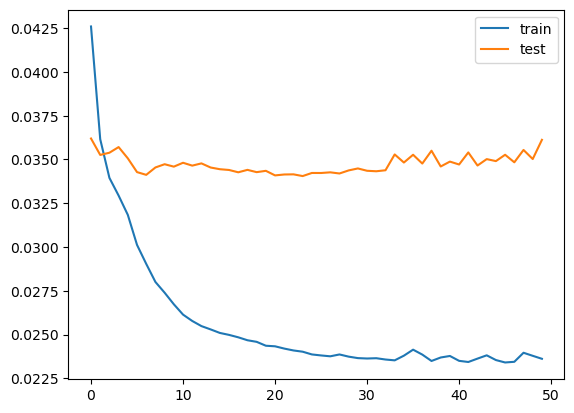

In [65]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [66]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)
print('Test RMSE: %.3f' % rmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.0003193490046154214
Test RMSE: 0.000


In [150]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge # RFE requires an estimator, often a simple model is used
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, RegressorMixin

In [151]:
X = values[:, :-1]
y = values[:, -1]
y.shape

(1399,)

In [152]:
sequence_length = 1
n_features = 15


In [153]:
class KerasReshapingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, keras_regressor, sequence_length=1):
        # We need to expose the keras_regressor's parameters for tuning!
        self.keras_regressor = keras_regressor
        self.sequence_length = sequence_length
        # Scikit-learn requires parameters to be set as attributes
        self.lstm_units = keras_regressor.lstm_units
        self.optimizer = keras_regressor.optimizer
        self.batch_size = keras_regressor.batch_size
        self.epochs = keras_regressor.epochs
        self.callbacks = keras_regressor.callbacks
        self.shuffle = keras_regressor.shuffle
        self.verbose = keras_regressor.verbose
    def fit(self, X, y):
        # 1. Perform the Reshaping (N, F) -> (N, 1, F)
        X_reshaped = X.reshape(X.shape[0], self.sequence_length, X.shape[1])
        
        # 2. Update the KerasRegressor with the actual shape
        # This is where we ensure the model builder gets the correct dimension
        # Note: We must update the model__input_shape on the actual keras_regressor instance
        # that will be used for fitting.
        
        # Get the feature count (F) after RFE has finished its transformation
        n_features = X.shape[1] 
        self.keras_regressor.set_params(
            model__input_shape=(self.sequence_length, n_features)
        )
        
        # 3. Fit the underlying Keras Regressor
        self.keras_regressor_ = self.keras_regressor.fit(X_reshaped, y)
        return self
    def predict(self, X):
        X_reshaped = X.reshape(X.shape[0], self.sequence_length, X.shape[1])
        return self.keras_regressor_.predict(X_reshaped)

In [154]:
def lstm_model(lstm_units=50, optimizer='adam', input_shape=None):
    model = Sequential()
    # try:
    #     n_features=meta['n_features_in_']
    # except(TypeError, KeyError):
    #     print("Warning: Could not extract n_features_in_ from meta. Setting to a default.")
    #     n_features = 1
    # input_shape_tuple = (sequence_length, n_features)
    model.add(LSTM(
        lstm_units,
        input_shape=input_shape
    ))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [155]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    mode='min',
    restore_best_weights=True
)

In [156]:
rfe_estimator = Ridge(random_state=42)
keras_regressor = KerasRegressor(
    model=lstm_model,
    lstm_units=50,
    optimizer='adam',
    epochs=200,
    batch_size=72,
    callbacks=[early_stop],
    verbose=0,
    shuffle=False,
)

In [157]:
reshaping_keras_step = KerasReshapingRegressor(
    keras_regressor=keras_regressor,
    sequence_length=sequence_length
)

In [122]:
rfe = RFE(
    estimator=rfe_estimator,
    step=1
)

In [158]:
full_pipeline = Pipeline([
    ('rfe', rfe),
    ('final_model', reshaping_keras_step)
])

In [159]:
tscsv = TimeSeriesSplit(n_splits=3)
param_dist = {
    'rfe__n_features_to_select': [3,6,9,12,15],
    'final_model__keras_regressor__lstm_units': [30, 50, 70],
    'final_model__keras_regressor__batch_size': [32, 64, 72]
}

In [163]:
random_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',
    cv=tscsv,
    verbose=1,
    n_jobs=-1
)

In [164]:
random_search.fit(X, y)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


,estimator,Pipeline(step...verbose=0)))])
,param_grid,"{'final_model__keras_regressor__batch_size': [32, 64, ...], 'final_model__keras_regressor__lstm_units': [30, 50, ...], 'rfe__n_features_to_select': [3, 6, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,estimator,Ridge(random_state=42)


In [165]:
print("\n### Final Results ###")
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Cross-Validation MSE: {-random_search.best_score_:.4f}")

# Extract selected features from the best pipeline
best_pipeline = random_search.best_estimator_
selected_feature_indices = best_pipeline.named_steps['rfe'].support_
feature_names = [f'Feature_{i}' for i in range(n_features)]
selected_features = np.array(feature_names)[selected_feature_indices]

print(f"\nOptimal Number of Features Selected: {random_search.best_params_['rfe__n_features_to_select']}")
print(f"Selected Features (Indices based on original 0-8 count): {selected_features}")


### Final Results ###
Best Hyperparameters: {'final_model__keras_regressor__batch_size': 72, 'final_model__keras_regressor__lstm_units': 70, 'rfe__n_features_to_select': 9}
Best Cross-Validation MSE: 0.0016

Optimal Number of Features Selected: 9
Selected Features (Indices based on original 0-8 count): ['Feature_0' 'Feature_1' 'Feature_2' 'Feature_5' 'Feature_6' 'Feature_7'
 'Feature_9' 'Feature_11' 'Feature_12']


In [167]:
26,28,55

(26, 28, 55)